In [ ]:
!pip install audiomentations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.0/77.0 kB 2.3 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
from tensorflow import keras
import librosa
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import audiomentations

In [ ]:
!wget -q -O training_files.zip https://www.dropbox.com/scl/fi/xefxidhnea3t6l5pkq6he/atleast_500.zip?rlkey=qe01cuxklk6ge1irpqarq7eoq&dl=0
!wget -q -O atleast_500.csv https://www.dropbox.com/scl/fi/tvoxpxnsolwv58fouk51o/atleast_500.csv?rlkey=m8uhqea3mysnpnjtc0aptkl93&dl=0

In [ ]:
!unzip -q 'training_files.zip'

In [ ]:
def read_file_paths(main_directory):
    main_directory = main_directory
    file_paths = []

    # go through all folders and get the paths of all .ogg audio files
    for root, directories, files in os.walk(main_directory):
        for file in files:
            if file.endswith('.wav'):
                file_path = os.path.join(root, file)
                file_paths.append(file_path)

    # os.walk may not go in alphabetical order thus it needs to be sorted
    file_paths.sort()
    return file_paths

In [ ]:
# Creating the dict with the numerical categoris to each filepath
filepaths = read_file_paths(os.getcwd())
df = pd.read_csv('atleast_500.csv')
df.drop(columns=['Unnamed: 0'], inplace=True)
df['Category'] = range(len(df))
labels = {filename: df[df['Bird'] == filename.split(os.path.sep)[-2]]['Category'].values[0] for filename in filepaths}

In [ ]:
train_paths, test_paths = train_test_split(filepaths, test_size=0.1, random_state=42)
partition = {'train': train_paths, 'test': test_paths}

In [ ]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, batch_size=32, dim=(128, 313), n_channels=1,
                 n_classes=30, shuffle=True, augmentation_prob=0.5):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.augmentation_prob = augmentation_prob
        self.augmenter = audiomentations.Compose([audiomentations.AddGaussianNoise(),audiomentations.TimeStretch(), audiomentations.PitchShift()])
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            audio, sr = librosa.load(ID, sr=None)

            if np.random.rand() < self.augmentation_prob:
                audio = self.augmenter(samples=audio, sample_rate=sr)

            spec = librosa.feature.melspectrogram(y=audio, sr=sr)
            spec_db = librosa.power_to_db(spec, ref=np.max)
            spec_normalized = (spec_db - spec_db.min()) / (spec_db.max() - spec_db.min())
            X[i,] = spec_normalized.reshape((*self.dim, self.n_channels))

            # Store class
            y[i] = self.labels[ID]

        return X, keras.utils.to_categorical(y, num_classes=self.n_classes)

In [ ]:
tg = DataGenerator(partition['train'], labels, batch_size=1)
x, y = tg._DataGenerator__data_generation(partition['train'][:1])
x.shape

(1, 128, 313, 1)

In [ ]:
training_generator = DataGenerator(partition['train'], labels, batch_size=64)
validation_generator = DataGenerator(partition['test'], labels, batch_size=64)

In [ ]:
es = keras.callbacks.EarlyStopping(patience=2, monitor='val_loss', verbose=1)
mc = keras.callbacks.ModelCheckpoint(filepath='best_model.h5', save_best_only=True, verbose=1)

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(32, (5,5), activation='relu', input_shape=(128, 313, 1)))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Conv2D(16, (5,5), activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dense(30, activation='softmax'))

In [ ]:
model.compile('Adam', loss='CategoricalCrossentropy', metrics=['accuracy', 'categorical_crossentropy', keras.metrics.Precision(), keras.metrics.Recall()])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 124, 309, 32)      832       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 62, 154, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 58, 150, 16)       12816     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 29, 75, 16)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 34800)             0         
                                                                 
 dropout_1 (Dropout)         (None, 34800)            

In [ ]:
num_epochs = 10

history = model.fit(x=training_generator,
                    epochs=num_epochs,
                    validation_data=validation_generator,
                    callbacks=[es, mc],
                    workers=4,  # Adjust the number of workers based on your system capabilities
                    use_multiprocessing=True)

model.save('final_model.h5')

Epoch 1/10
667/667 [==============================] - ETA: 0s - loss: 1.9739 - accuracy: 0.4654 - categorical_crossentropy: 1.9739 - precision_1: 0.8172 - recall_1: 0.2660
Epoch 1: val_loss improved from inf to 1.47470, saving model to best_model.h5
667/667 [==============================] - 2085s 3s/step - loss: 1.9739 - accuracy: 0.4654 - categorical_crossentropy: 1.9739 - precision_1: 0.8172 - recall_1: 0.2660 - val_loss: 1.4747 - val_accuracy: 0.5912 - val_categorical_crossentropy: 1.4747 - val_precision_1: 0.8604 - val_recall_1: 0.4060
Epoch 2/10


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


667/667 [==============================] - ETA: 0s - loss: 1.3389 - accuracy: 0.6295 - categorical_crossentropy: 1.3389 - precision_1: 0.8490 - recall_1: 0.4758
Epoch 2: val_loss improved from 1.47470 to 1.26865, saving model to best_model.h5
667/667 [==============================] - 2081s 3s/step - loss: 1.3389 - accuracy: 0.6295 - categorical_crossentropy: 1.3389 - precision_1: 0.8490 - recall_1: 0.4758 - val_loss: 1.2687 - val_accuracy: 0.6415 - val_categorical_crossentropy: 1.2687 - val_precision_1: 0.8514 - val_recall_1: 0.4973
Epoch 3/10
667/667 [==============================] - ETA: 0s - loss: 1.1126 - accuracy: 0.6902 - categorical_crossentropy: 1.1126 - precision_1: 0.8655 - recall_1: 0.5658
Epoch 3: val_loss improved from 1.26865 to 1.15312, saving model to best_model.h5
667/667 [==============================] - 2073s 3s/step - loss: 1.1126 - accuracy: 0.6902 - categorical_crossentropy: 1.1126 - precision_1: 0.8655 - recall_1: 0.5658 - val_loss: 1.1531 - val_accuracy: 0.67

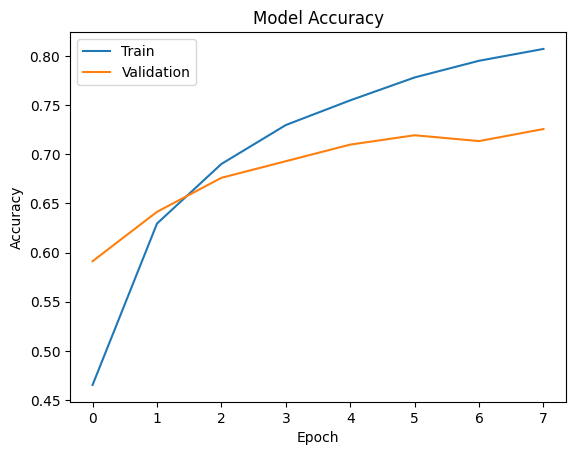

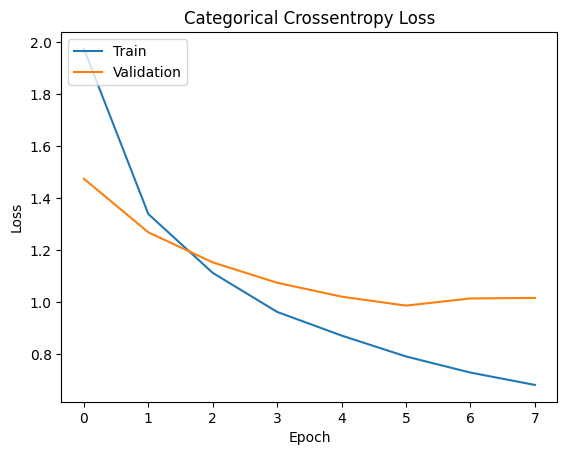

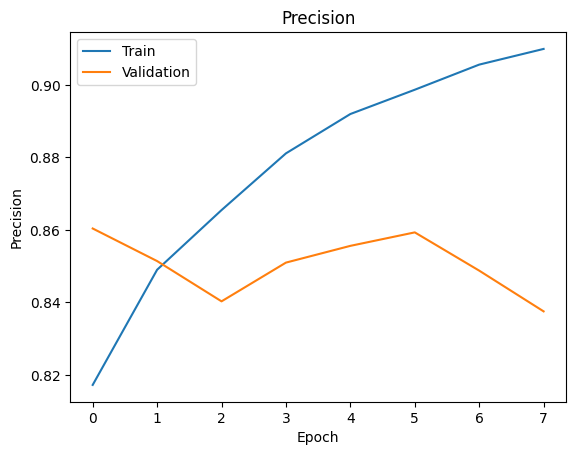

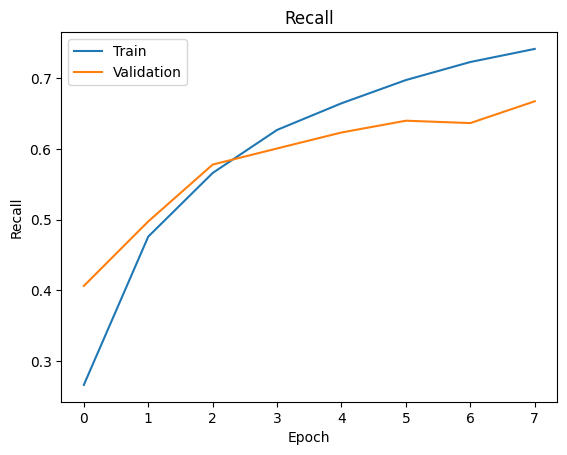

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['categorical_crossentropy'])
plt.plot(history.history['val_categorical_crossentropy'])
plt.title('Categorical Crossentropy Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation precision values
plt.plot(history.history['precision_1'])
plt.plot(history.history['val_precision_1'])
plt.title('Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation recall values
plt.plot(history.history['recall_1'])
plt.plot(history.history['val_recall_1'])
plt.title('Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
import random

def simpleevaluation(eval_set, iterations, model, df):
    predictions = {}
    for i in range(iterations):
        current_sample = eval_set[random.randint(0, len(eval_set))]
        y, sr = librosa.load(current_sample, sr=None)
        spec = librosa.feature.melspectrogram(y=y, sr=sr)
        spec_db = librosa.power_to_db(spec, ref=np.max)
        spec_normalized = (spec_db - spec_db.min()) / (spec_db.max() - spec_db.min())
        final_spec = np.array([spec_normalized.reshape((128, 313, 1))])

        prediction = model.predict(final_spec)
        prediction_index = np.where(prediction == np.max(prediction))[1][0]
        prediction_label = df[df['Category'] == prediction_index]['Bird'].values[0]
        actual_label = current_sample.split(os.path.sep)[-2]
        predictions[i] = {'predicted label': prediction_label,
                          'probability': np.max(prediction),
                          'actual label': actual_label}
    return predictions


In [ ]:
eval = simpleevaluation(partition['test'], 5, model, df)
for key, value in eval.items():
    print(f'Predicted bird: {value["predicted label"]} with likeliness of {value["probability"]}, actual bird: {value["actual label"]}')

1/1 [==============================] - 0s 36ms/step
Predicted bird: hoopoe with likeliness of 0.4876086115837097, actual bird: hoopoe
Predicted bird: eaywag1 with likeliness of 0.9842206239700317, actual bird: eaywag1
Predicted bird: thrnig1 with likeliness of 1.0, actual bird: thrnig1
Predicted bird: woosan with likeliness of 0.9999992847442627, actual bird: woosan
Predicted bird: rbsrob1 with likeliness of 0.9601677060127258, actual bird: rbsrob1
